## Imports

In [4]:
%pylab inline
import numpy as np
from tqdm import *

Populating the interactive namespace from numpy and matplotlib


/Users/hrishioa/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Initialization
-------------

Set up Hyperparameters
* InputSize
* OutputSize
* HiddenLayerWidth
* HiddenLayerHeight

In [11]:
class perceptron(object):
    def __init__(self, input_size, output_size, hl_neurons, hl_layers, learningrate):
        self.learningrate = learningrate
        self.input_size = input_size
        self.output_size = output_size
        self.hl_neurons = hl_neurons
        self.hl_layers = hl_layers
        
        # Now setup the weights in this format (inputs x neurons)
        self.weights = []
        self.ths = []
        self.weights.append(self.get_weights((hl_neurons, input_size)))
        self.ths.append(self.get_weights((hl_neurons, 1)))
        for i in xrange(1, hl_layers):
            self.weights.append(self.get_weights((hl_neurons, hl_neurons)))
            self.ths.append(self.get_weights((hl_neurons, 1)))
        self.weights.append(self.get_weights((output_size, hl_neurons)))
        self.ths.append(self.get_weights((output_size, 1)))
        self.delta_func = self.delta_func1
        self.sigmoid = np.vectorize(self.sigmoid)
        self.sigmoid_delta = np.vectorize(self.sigmoid_delta)
        
    def get_weights(self, dimensions):
        return np.random.normal(0,1,dimensions)
        
    def delta_func1(self, output, truths):
        return (output-truths)
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def sigmoid_delta(self, z):
        return (np.exp(-z))/((1+np.exp(-z))**2)
    
    def push_forward(self, inputs):
        A = []
        Z = []
        output = inputs
        for i in xrange(0, len(self.weights)):
#             print "performing %f * %f + %f" % (np.max(self.weights[i]), np.max(output), np.max(self.ths[i]))
            normno = len(output)
            output = np.dot(self.weights[i], output)
            output /= normno
#             print "Dividing by %d neurons" % normno
            output += self.ths[i]
            Z.append(output)
            output = self.sigmoid(output)
            A.append(output)
        return A, Z, output
    
    def feed_forward(self, inputs):
        print "input = %s" % (inputs)
        _, _, output = self.push_forward(inputs)
        return output
    
    def multiply_and_average(self, delta, A):
        At = np.transpose(A)
        # Multiply the two, see if they're compatible (faster than throwing an exception)
        _ = np.dot(delta,At)
        ws = []
        for i in xrange(0, len(delta[0])):
            di = delta[:,[i]]
            Ai = At[[i],:]
            ws.append(np.dot(di, Ai))
        return np.mean(ws,axis=0)
    
    def train(self, inputs, truths):
        # First get the error and delta for output layer
        A, Z, output = self.push_forward(inputs)
#         curdelta = np.multiply((output - truths),self.sigmoid_delta(Z[len(Z)-1]))
        curdelta = np.multiply(self.delta_func(output, truths),self.sigmoid_delta(Z[len(Z)-1]))
        deltas = [curdelta]
        for i in reversed(xrange(0, len(self.weights)-1)):
            curdelta = np.multiply(np.dot(np.transpose(self.weights[i+1]), curdelta),
                                   self.sigmoid_delta(Z[i]))
            deltas.insert(0, curdelta)        
        A.insert(0,inputs)
        for i in reversed(xrange(0, len(self.weights))):
            self.weights[i] -= (self.learningrate * np.dot(deltas[i], A[i].T))
            tmp = np.mean(deltas[i],axis=1)
            tmp = np.matrix(tmp)
            tmp = tmp.T
            try:
                self.ths[i] -= (self.learningrate * tmp)
            except ValueError:
#                 print "tmp - %s" % tmp
#                 print "ths - %s" % self.ths[i]
                self.ths[i] -= (self.learningrate * tmp.T)
            
        return np.mean(abs(truths - output))

Testing Input (AND)
---------
Sample truth table for AND:

A | B | **Output**
--- | --- | ---
0 | 0 | 0
0 | 1 | 0
1 | 0 | 0
1 | 1 | 1

In [12]:
input_XOR = np.transpose(np.array([[0,0],[0,1],[1,0],[1,1]]))
gtruth_XOR = np.transpose(np.array([[0],[1],[1],[0]]))
input_AND = np.transpose(np.array([[0,0],[0,1],[1,0],[1,1]]))
gtruth_AND = np.transpose(np.array([[0],[0],[0],[1]]))

input = [[0 0 1 1]
 [0 1 0 1]]
Final Results: [[ 0.50989372  0.50090598  0.49967721  0.49047048]]
CPU times: user 568 ms, sys: 31.3 ms, total: 599 ms
Wall time: 982 ms


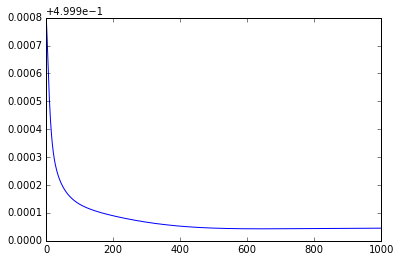

In [13]:
%%time
np.random.seed(1)
pp = perceptron(2, 1, 1, 1, 1.0)
results = []
for i in xrange(0, 1000): results.append(pp.train(input_XOR, gtruth_XOR))
plot(results)
print "Final Results: %s" % pp.feed_forward(input_XOR)

We can clearly see the training fail here, when we're training for XOR with only one neuron in the hidden layer, and the training fails. Let's try with two neurons:

100%|██████████| 1000/1000 [00:01<00:00, 947.91it/s]

input = [[0 0 1 1]
 [0 1 0 1]]
Final Results = [[ 0.01227833  0.97995318  0.98203135  0.02233572]]
CPU times: user 686 ms, sys: 25 ms, total: 711 ms
Wall time: 1.35 s


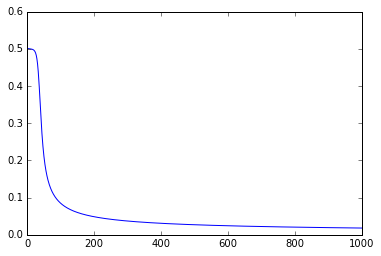

In [14]:
%%time
np.random.seed(1)
pp2 = perceptron(2, 1, 3, 1, 10)
plot([(pp2.train(input_XOR, gtruth_XOR)) for i in tqdm(xrange(0, 1000))])
print "Final Results = %s" % pp2.feed_forward(input_XOR)

The results look much better now.

In [15]:
pp2.feed_forward([[1],[0]])

input = [[1], [0]]


array([[ 0.98203135]])

Cross Entropy
------------

Now let us try modifying the cost function, see if we can't speed up computation a bit.
The ordinary cost derivative being used is:
$$\frac{dE}{dA} = (a-y)$$
Cross entropy uses the following function:
$$\frac{dE}{dA} = \frac{a-y}{a(1-a)}$$

In [16]:
def cross_delta(output, truths):
    return (output - truths)/(np.multiply(output,(1-output)))

100%|██████████| 5000/5000 [00:04<00:00, 1155.05it/s]

input = [[0 0 1 1]
 [0 1 0 1]]
Cross Entropy Final Results = [[  1.01614339e-03   9.99354624e-01   9.97951898e-01   8.63890463e-04]]
input = [[0 0 1 1]
 [0 1 0 1]]
L2NORM        Final Results = [[ 0.02620925  0.97927702  0.96468645  0.02231536]]
CPU times: user 4.93 s, sys: 67.8 ms, total: 5 s
Wall time: 7.03 s


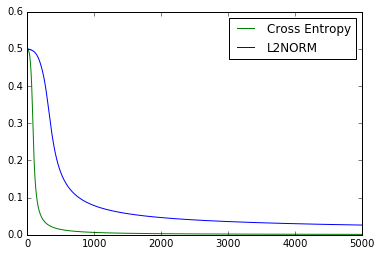

In [18]:
%%time
np.random.seed(2)
pp2 = perceptron(2, 1, 3, 1, 1)
np.random.seed(2)
pp3 = perceptron(2, 1, 3, 1, 1)
pp3.delta_func = cross_delta
plot([(pp3.train(input_XOR, gtruth_XOR)) for i in tqdm(xrange(0, 5000))], "green",label = "Cross Entropy")
plot([(pp2.train(input_XOR, gtruth_XOR)) for i in tqdm(xrange(0, 5000))], "blue", label = "L2NORM")
legend()
print "Cross Entropy Final Results = %s" % pp3.feed_forward(input_XOR)
print "L2NORM        Final Results = %s" % pp2.feed_forward(input_XOR)

We can clearly see the difference in training speed and training time.

Digit Classification
----

Now let's load some MNIST digits and attempt classification. We'll use the MNIST package to make loading from the compressed files easier.

In [19]:
from mnist import MNIST
mndata = MNIST('mnist')
data = mndata.load_training()

In [131]:
training_images = data[0]
training_labels = data[1]

Now we can attempt to create a neural net that can process the data. First thing is something to convert label data into useful ground truths for the perceptron, as well as some input processing to normalize input data.

In [132]:
def out_process(digit):
    outv = np.zeros(10)
    outv[digit] = 1
    return outv
def in_process(inval):
    return inval/255.0

In [133]:
np.random.seed(1)
mnist_pp = perceptron(len(training_images[0]), 10, 15, 2, 0.1)

In [134]:
## Reshape and fit training data
# selection_max = 100
selection_max = len(training_images)
def load_images(inp, selection_max, T=True):
    if(selection_max == -1): selection_max = len(inp)
    if(T):
        return in_process(np.matrix(inp[0:selection_max]).T)
    else:
        return in_process(np.matrix(inp[0:selection_max]).T)

training_data = load_images(training_images, selection_max)

In [135]:
## Reshape and fit labels
def load_labels(inp, selection_max):
    return numpy.apply_along_axis(func1d=out_process, arr=np.matrix(inp[0:selection_max]), axis=0)
training_data_l = load_labels(training_labels, selection_max)

In [30]:
%%time
## Testing feed forward
y = mnist_pp.feed_forward(training_data)

Wall time: 3.77 s


In [31]:
error = y - training_data_l
print y.shape
print training_data_l.shape
_, _, output = mnist_pp.push_forward(training_data)
print np.mean(abs(training_data_l - output))

(10L, 60000L)
(10L, 60000L)
0.899602980018


In [ ]:
%%time
## Fingers crossed, try training
plot([(mnist_pp.train(training_data, training_data_l)) for i in tqdm(xrange(0, 1000))], "green",label = "Cost")
legend()

  0%|▏                                                                                     | 2/1000 [00:21<2:57:32, 10.67s/it]C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:27: RuntimeWarning: overflow encountered in exp
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: RuntimeWarning: overflow encountered in exp
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: RuntimeWarning: invalid value encountered in double_scalars
  1%|▌                                                                                     | 6/1000 [01:21<3:56:23, 14.27s/it]

For the safety of time, let's start using cross entropy.

In [24]:
%%time
np.random.seed(1)
mnist_pp2 = perceptron(len(training_images[0]), 10, 15, 2, 0.1)
mnist_pp2.delta_func = cross_delta

Wall time: 0 ns


%%time
res = [float((mnist_pp2.train(training_data, training_data_l))) for i in tqdm(xrange(0, 10000))]
plot(res, "green",label = "Cost")
legend()

Since the dataset is large, and training takes an inordinate amount of time, we need to try other methods.

## Mini-Batch Gradient Descent

In [162]:
def getbatch(training_set, training_set_l, batch_size=50):
    l, b = training_set.shape
    selection = np.random.randint(0,b, size=batch_size)
    return (training_set[:,np.array(selection)], training_set_l[:,np.array(selection)])
a, b = getbatch(training_data, training_data_l, 50)
print a.shape
print b.shape

(784L, 50L)
(10L, 50L)


In [163]:
print len(training_data[:, :])
training_data.shape

784


(784L, 60000L)

In [164]:
## Check shapes
print training_data[1,2]
print training_data.shape
print training_data_l.shape

0.0
(784L, 60000L)
(10L, 60000L)


Now, we can start training. Let's try a batch size of 50 over 1000 tries.

In [257]:
np.random.seed(1)
mnist_pp3 = perceptron(len(training_images[0]), 10, 10, 4, 10)
# mnist_pp3.delta_func = cross_delta

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]

Wall time: 40 ms


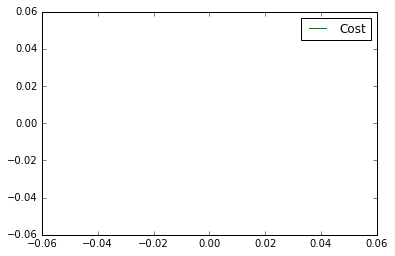

In [264]:
%%time
res = [(mnist_pp3.train(*(getbatch(training_data, training_data_l, 1)))) for i in tqdm(xrange(0, 1))]
plot(res, "green",label = "Cost")
legend()

In [253]:
t, tl = getbatch(training_data, training_data_l, 3)

In [260]:
res

[0.67871356978686581,
 0.25667445874395528,
 0.10414331615370873,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [254]:
mnist_pp3.feed_forward(training_data[:,1:4])

input = [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 ..., 
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


matrix([[ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan]])

In [249]:
a, z, output = mnist_pp3.push_forward(training_data[:,1:4])
for i in xrange(0, len(a)): print "a[%d]: %s" % (i, a[i])
for i in xrange(0, len(z)): print "z[%d]: %s" % (i, z[i])

Dividing by 784 neurons
Dividing by 10 neurons
Dividing by 10 neurons
Dividing by 10 neurons
Dividing by 10 neurons
a[0]: [[ 0.32316022  0.338594    0.33348225]
 [ 0.27188617  0.28907415  0.28580044]
 [ 0.52441801  0.53393797  0.5304523 ]
 [ 0.22596119  0.23928328  0.23686373]
 [ 0.4344431   0.4485956   0.44579932]
 [ 0.10528021  0.11585239  0.11407259]
 [ 0.34125604  0.35742485  0.35429641]
 [ 0.3045872   0.31500539  0.31103056]
 [ 0.16416333  0.1760405   0.17316591]
 [ 0.18213741  0.19356041  0.19131405]]
a[1]: [[ 0.12833022  0.12783261  0.12797537]
 [ 0.27555196  0.27439401  0.27470415]
 [ 0.16855674  0.16775356  0.16793113]
 [ 0.153762    0.15296163  0.15316397]
 [ 0.15389297  0.15263569  0.1529381 ]
 [ 0.20207071  0.2012792   0.20146544]
 [ 0.11551598  0.11468809  0.11489005]
 [ 0.18482193  0.18390908  0.18412064]
 [ 0.19473969  0.19407884  0.19426173]
 [ 0.2647457   0.26344189  0.26377597]]
a[2]: [[ 0.69943092  0.69941225  0.69941714]
 [ 0.94112174  0.94108901  0.94109722]
 [ 0.8